# load raw radar data

In [1]:
import numpy as np
import zipfile
import os
import re
from functools import cmp_to_key
from datetime import datetime, timedelta
import tqdm

data_dir = "data/zuimei-radar"

def remove_invalid_zips(directory):
    file_paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.zip'):
                file_path = os.path.join(root, file)
                file_paths.append(file_path)
                
                try:
                    with zipfile.ZipFile(file_path, 'r') as zip_file:
                        # Check if the ZIP file is complete
                        bad_file = zip_file.testzip()
                        if bad_file is None:
                            # The ZIP file is complete
                            file_paths.append(file_path)
                        else:
                            print(f"Warning: '{file_path}' is a corrupted ZIP file.")
                            os.remove(file_path)
                            print(f"The file {file_path} has been removed.") 
                except zipfile.BadZipFile:
                    print(f"Warning: '{file_path}' is not a valid ZIP file.")
                    os.remove(file_path)
                    print(f"The file {file_path} has been removed.") 
                    
    return file_paths

def get_file_paths(directory):
    file_paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.zip'):
                file_path = os.path.join(root, file)
                file_paths.append(file_path)
                
                # try:
                #     with zipfile.ZipFile(file_path, 'r') as zip_file:
                #         # Check if the ZIP file is complete
                #         bad_file = zip_file.testzip()
                #         if bad_file is None:
                #             # The ZIP file is complete
                #             file_paths.append(file_path)
                #         else:
                #             print(f"Warning: '{file_path}' is a corrupted ZIP file.")
                # except zipfile.BadZipFile:
                #     print(f"Warning: '{file_path}' is not a valid ZIP file.")
                    
    return file_paths


def sort_key(file_path):
    match = re.search(r'BABJ_(\d+)_P', file_path)
    if match:
        return int(match.group(1))
    else:
        return float('inf')

# Example usage

# remove_invalid_zips(data_dir)

file_paths = get_file_paths(data_dir)
print(f"number of files: {len(file_paths)}")
print("before sort: \n", file_paths[:5])

file_paths.sort(key=cmp_to_key(lambda x, y: (sort_key(x) > sort_key(y)) - (sort_key(x) < sort_key(y))))

print("after sort: \n", file_paths[:5])

# keep only items with 6 min intervals
file_paths_new = []

for file_path in file_paths:
    match = re.search(r'BABJ_(\d+)_P', file_path)
    if not match:
        print(file_path)
        continue
    
    minutes = int(match.group(1)[-4:-2])
    if minutes % 6 == 0:
        file_paths_new.append(file_path)
    else:
        print(file_path)
    

file_paths = file_paths_new

# get consecutive time periods
def get_time_from_path(file_path, return_type='datetime'):
    match = re.search(r'BABJ_(\d+)_P', file_path)
    if match:
        time_str = match.group(1)
        if return_type == 'datetime':
            return datetime.strptime(time_str, '%Y%m%d%H%M%S')
        else:
            return time_str
    else:
        return None

times = [get_time_from_path(path) for path in file_paths]
times.sort()

periods = []
current_period = []

for i in range(len(times)):
    current_time = times[i]
    if i == 0 or (times[i] - times[i - 1]).total_seconds() >= 355 and (times[i] - times[i - 1]).total_seconds() <= 365:
        current_period.append(file_paths[i])
    else:
        periods.append(current_period)
        current_period = [file_paths[i]]

if current_period:
    periods.append(current_period)

print(f"Periods of consecutive file paths: {len(periods)}")
# for period in periods[:5]:
#     print(period)

def read_data(file_path):
    # Open the ZIP file
    with zipfile.ZipFile(file_path, 'r') as zip_file:
        # Get the name of the file inside the ZIP archive
        file_name = zip_file.namelist()[0]

        # Open the file inside the ZIP archive
        with zip_file.open(file_name) as file:
            # Load the NumPy array from the file
            data = np.loadtxt(file)
    
    return data

        
# Print the loaded NumPy array
data = read_data(file_paths[0])
print(type(data), data.shape)

number of files: 7223
before sort: 
 ['data/zuimei-radar/20240314/Z_RADA_C_BABJ_20240313175414_P_ACHN.QREF.20240313.174800.bin.zip', 'data/zuimei-radar/20240314/Z_RADA_C_BABJ_20240314143014_P_ACHN.QREF.20240314.142400.bin.zip', 'data/zuimei-radar/20240314/Z_RADA_C_BABJ_20240314141214_P_ACHN.QREF.20240314.140600.bin.zip', 'data/zuimei-radar/20240314/Z_RADA_C_BABJ_20240314094813_P_ACHN.QREF.20240314.094200.bin.zip', 'data/zuimei-radar/20240314/Z_RADA_C_BABJ_20240314050015_P_ACHN.QREF.20240314.045400.bin.zip']
after sort: 
 ['data/zuimei-radar/20240301/Z_RADA_C_BABJ_20240229160014_P_ACHN.QREF.20240229.155400.bin.zip', 'data/zuimei-radar/20240301/Z_RADA_C_BABJ_20240229160614_P_ACHN.QREF.20240229.160000.bin.zip', 'data/zuimei-radar/20240301/Z_RADA_C_BABJ_20240229161214_P_ACHN.QREF.20240229.160600.bin.zip', 'data/zuimei-radar/20240301/Z_RADA_C_BABJ_20240229161814_P_ACHN.QREF.20240229.161200.bin.zip', 'data/zuimei-radar/20240301/Z_RADA_C_BABJ_20240229162415_P_ACHN.QREF.20240229.161800.bin.zip

In [2]:
data.dtype

dtype('float64')

# analyze the data

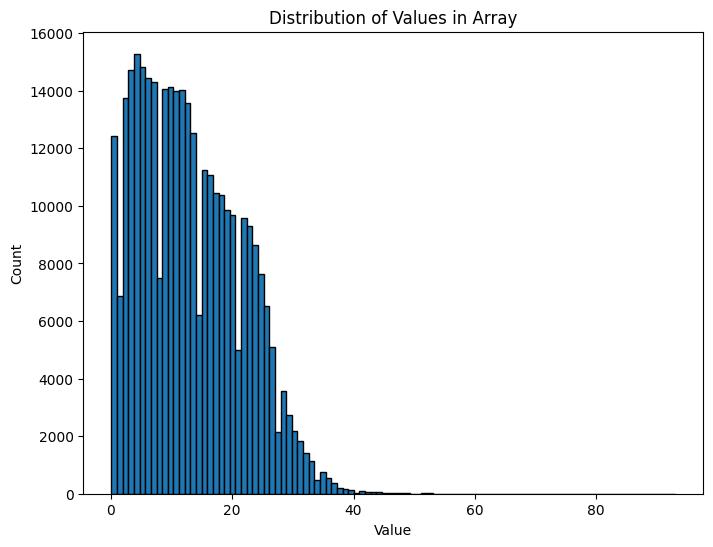

In [3]:
import matplotlib.pyplot as plt

data = data[~np.isnan(data)]
data = data[data>0]

# Plot the distribution
plt.figure(figsize=(8, 6))
plt.hist(data, bins=100, edgecolor='black')
plt.title('Distribution of Values in Array')
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()

In [4]:
print(len(periods))

142


In [5]:
count = sum([1 for period in periods if len(period)>=24])

lens = [len(period) for period in periods if len(period)>=0]
print(count)
print(lens)

15
[18, 4, 4, 14, 4, 29, 4, 9, 14, 8, 14, 4, 4, 4, 4, 4, 9, 4, 4, 14, 4, 9, 4, 9, 4, 14, 14, 4, 49, 4, 9, 9, 9, 14, 24, 4, 4, 4, 19, 14, 9, 4, 4, 14, 4, 4, 34, 4, 12, 6, 14, 9, 9, 3, 4, 9, 4, 14, 4, 4, 4, 4, 4, 4, 19, 4, 14, 9, 9, 9, 14, 19, 4, 4, 4, 14, 9, 9, 9, 9, 29, 4, 4, 4, 4, 9, 4, 19, 4, 9, 14, 14, 14, 14, 4, 4, 4, 4, 4, 4, 4, 14, 4, 9, 19, 14, 14, 4, 4, 9, 14, 14, 14, 14, 14, 4, 4, 39, 4, 4, 14, 4, 9, 9, 3642, 35, 1, 127, 1, 519, 1, 153, 4, 2, 2, 1, 1, 1, 632, 293, 59, 572]


## for each consecutive periods with length >= 24, prepeare examples

In [6]:
import numpy as np
from tqdm import tqdm
import time

def read_data(file_path):
    # Open the ZIP file
    with zipfile.ZipFile(file_path, 'r') as zip_file:
        # Get the name of the file inside the ZIP archive
        file_name = zip_file.namelist()[0]

        # Open the file inside the ZIP archive
        with zip_file.open(file_name) as file:
            # Load the NumPy array from the file
            data = np.loadtxt(file)
    
    return data


def read_frames(file_paths, vmin=0, vmax=75):
    
    frames = []
    for file_path in file_paths:
        try:
            data = read_data(file_path)
            frames.append(data)
        except Exception as e:
            print(f"{e}: {file_path}")
    
    frames = np.stack(frames, axis=0)
    frames[np.isnan(frames)] = 0
    frames[frames>vmax] = vmax
    frames[frames<vmin] = vmin
    frames = frames.astype(np.float32)
    
    return frames


def compute_integral_image(image):
    """Compute the integral image of a given image."""
    integral_image = np.zeros_like(image)
    rows, cols = image.shape
    
    # Compute the integral image
    for i in range(rows):
        for j in range(cols):
            integral_image[i, j] = 1 if image[i, j] > 0 else 0
            if i > 0:
                integral_image[i, j] += integral_image[i-1, j]
            if j > 0:
                integral_image[i, j] += integral_image[i, j-1]
            if i > 0 and j > 0:
                integral_image[i, j] -= integral_image[i-1, j-1]
                
    return integral_image


def get_window_sum(integral_image, top_left, bottom_right):
    """Compute the sum of pixel values in a window using the integral image."""
    top, left = top_left
    bottom, right = bottom_right
    
    window_sum = integral_image[bottom, right]
    if top > 0:
        window_sum -= integral_image[top-1, right]
    if left > 0:
        window_sum -= integral_image[bottom, left-1]
    if top > 0 and left > 0:
        window_sum += integral_image[top-1, left-1]
        
    return window_sum


def crop_image(image, crop_size=256, num_thr=50):
    # Compute the integral image
    integral_image = compute_integral_image(image)
    
    # Get the dimensions of the image
    rows, cols = image.shape
    
    # Initialize variables to keep track of the maximum non-zero count and its position
    max_count = -1
    max_pos = (0, 0)
    
    valid_positions = []
    # Slide the window across the integral image
    for i in range(0, rows - crop_size + 1):
        for j in range(0, cols - crop_size + 1):
            # Compute the sum of pixel values in the current window
            count = get_window_sum(integral_image, (i, j), (i+crop_size-1, j+crop_size-1))
            
            # Update the maximum count and its position if the current count is greater
            if count > max_count:
                max_count = count
                max_pos = (i, j)
            
            if count > num_thr:
                valid_positions.append((i, j))
    
    # Crop the image using the position with the maximum count
    cropped_image_max_nonzero = image[max_pos[0]:max_pos[0]+crop_size, max_pos[1]:max_pos[1]+crop_size]
    
    # If no valid position found, raise an exception
    if not valid_positions:
        raise ValueError("No valid crop position found with the given threshold.")

    # Select a random valid position
    random_idx = np.random.choice(len(valid_positions))
    random_pos = valid_positions[random_idx]

    # Crop the array
    cropped_image_random = image[random_pos[0]:random_pos[0]+crop_size,
                         random_pos[1]:random_pos[1]+crop_size]

    result = {
        "cropped_image_max_nonzero": cropped_image_max_nonzero,
        "max_pos": max_pos,
        "cropped_image_random": cropped_image_random,
        "random_pos": random_pos,
        "valid_positions": valid_positions
    }
    
    return result


def crop_frames(frames, crop_size=256, num_thr=100):
    # used to crop the large frame into small frames
    result = crop_image(frames[0], crop_size=crop_size, num_thr=num_thr)
    
    max_pos = result['max_pos']
    cropped_frames_max_nonzero = frames[:,max_pos[0]:max_pos[0]+crop_size, max_pos[1]+max_pos[1]+crop_size]
    
    random_pos = result['random_pos']
    cropped_frames_random= frames[:,random_pos[0]:random_pos[0]+crop_size, random_pos[1]+random_pos[1]+crop_size]
    
    cropped_result = {
        "cropped_frames_max_nonzero": cropped_frames_max_nonzero,
        "max_pos": max_pos,
        "cropped_frames_random": cropped_frames_random,
        "random_pos": random_pos
    }
    
    return cropped_result

In [ ]:
examples = []

crop_size = 256
num_thr = 1000 # for random cropping, ensure that the cropped area has at least this number of elements are nonzero

num_periods = 30000 
num_total_frames = 24

for period in tqdm(periods[:num_periods]):
    if len(period) < num_total_frames:
        continue
    
    start_reading = time.time()
    print(f"Start reading {len(period)} frames ...")
    period_frames = read_frames(period)
    end_reading = time.time()
    time_cost_reading = end_reading - start_reading
    print(f"End reading {len(period)} frames, time cost: {time_cost_reading:.2f}s.")
    
    freq_update_crop_region = 240 # change crop regions every 24 hours, 240 * 6 min
    
    frame_result = {"max_pos": (0, 0), "valid_positions": [(0, 0)]}
    
    print("Start croppping")
    num_examples = len(period)-num_total_frames+1
    for idx in tqdm(range(num_examples)):
        frames = period_frames[idx:idx+num_total_frames]
        
        if idx % freq_update_crop_region == 0:
            frame_result = crop_image(frames[0], crop_size, num_thr)
        
        max_pos = frame_result['max_pos']
        cropped_frames_max_nonzero = frames[:,max_pos[0]:max_pos[0]+crop_size, max_pos[1]:max_pos[1]+crop_size]

        random_idx = np.random.choice(len(frame_result["valid_positions"]))
        random_pos = frame_result["valid_positions"][random_idx]
        cropped_frames_random= frames[:,random_pos[0]:random_pos[0]+crop_size, random_pos[1]:random_pos[1]+crop_size]
        
        frame_start_time = get_time_from_path(period[idx], 'str')
        
        cropped_result = {
            "cropped_frames_max_nonzero": cropped_frames_max_nonzero,
            "max_pos": max_pos,
            "cropped_frames_random": cropped_frames_random,
            "random_pos": random_pos,
            "start_time": frame_start_time
        }
        
        examples.append(cropped_result)
    
    end_crop = time.time()
    time_cost_crop = end_crop - end_reading
    print(f"End cropping {num_examples} frames, time cost: {time_cost_crop}s, average time cost: {time_cost_crop/num_examples:.2f}s")

  0%|          | 0/142 [00:00<?, ?it/s]

Start reading 29 frames ...
End reading 29 frames, time cost: 81.61s.
Start croppping



  4%|▍         | 6/142 [04:25<1:40:15, 44.23s/it]

End cropping 6 frames, time cost: 183.78415703773499s, average time cost: 30.63s
Start reading 49 frames ...
End reading 49 frames, time cost: 134.59s.
Start croppping



 20%|██        | 29/142 [09:43<34:52, 18.52s/it] 

End cropping 26 frames, time cost: 183.38623023033142s, average time cost: 7.05s
Start reading 24 frames ...
End reading 24 frames, time cost: 71.28s.
Start croppping



 25%|██▍       | 35/142 [13:58<43:15, 24.26s/it]

End cropping 1 frames, time cost: 183.58407592773438s, average time cost: 183.58s
Start reading 34 frames ...
End reading 34 frames, time cost: 94.19s.
Start croppping



 33%|███▎      | 47/142 [18:37<37:46, 23.85s/it]

End cropping 11 frames, time cost: 184.93554639816284s, average time cost: 16.81s
Start reading 29 frames ...
End reading 29 frames, time cost: 86.51s.
Start croppping



 57%|█████▋    | 81/142 [23:08<14:12, 13.98s/it]

End cropping 6 frames, time cost: 184.55476140975952s, average time cost: 30.76s
Start reading 39 frames ...
End reading 39 frames, time cost: 110.58s.
Start croppping



 83%|████████▎ | 118/142 [28:02<04:24, 11.02s/it]

End cropping 16 frames, time cost: 183.87262344360352s, average time cost: 11.49s
Start reading 3642 frames ...


In [ ]:
len(examples)

## visualize the cropped images

In [ ]:
import datetime
import os

import cartopy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import shapely.geometry as sgeom
import tensorflow as tf
# import tensorflow_hub

matplotlib.rc('animation', html='jshtml')

def plot_radar_image(radar_image, vmin=0, vmax=75):
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the data as an image
    im = ax.imshow(radar_image, vmin=vmin, vmax=vmax, cmap='jet')  # viridis 

    # Add a colorbar beside the figure
    cbar = fig.colorbar(im, ax=ax, shrink=1)

    # Add a label to the colorbar
    cbar.set_label('Radar signal strength (dbz)', rotation=270, labelpad=20)
    # plt.imshow(cropped_frames[0, ...], vmin=0, vmax=10, cmap='jet')
    plt.show()

    
def plot_animation(field, figsize=None, vmin=0, vmax=10, cmap="jet", **imshow_args):
    fig = plt.figure(figsize=figsize)
    ax = plt.axes()
    ax.set_axis_off()
    plt.close() # Prevents extra axes being plotted below animation
    img = ax.imshow(field[0, ..., 0], vmin=vmin, vmax=vmax, cmap=cmap, **imshow_args)

    def animate(i):
        img.set_data(field[i, ..., 0])
        return (img,)

    return animation.FuncAnimation(
      fig, animate, frames=field.shape[0], interval=24, blit=False)


class ExtendedOSGB(cartopy.crs.OSGB):
    """MET office radar data uses OSGB36 with an extended bounding box."""

    def __init__(self):
        super().__init__(approx=False)

    @property
    def x_limits(self):
        return (-405000, 1320000)

    @property
    def y_limits(self):
        return (-625000, 1550000)
    
    @property
    def boundary(self):
        x0, x1 = self.x_limits
        y0, y1 = self.y_limits
        return sgeom.LinearRing([(x0, y0), (x0, y1), (x1, y1), (x1, y0), (x0, y0)])


def plot_rows_on_map(rows, field_name="radar_frames", timestep=0, num_rows=None,
                     cbar_label=None, **imshow_kwargs):
    fig = plt.figure(figsize=(10, 10))
    axes = fig.add_subplot(1, 1, 1, projection=ExtendedOSGB())
    if num_rows is None:
        num_rows = next(iter(rows.values())).shape[0]
    for b in range(num_rows):
        extent = (rows["osgb_extent_left"][b].numpy(),
                  rows["osgb_extent_right"][b].numpy(),
                  rows["osgb_extent_bottom"][b].numpy(),
                  rows["osgb_extent_top"][b].numpy())
        im = axes.imshow(rows[field_name][b, timestep, ..., 0].numpy(),
                    extent=extent, **imshow_kwargs)

    axes.set_xlim(*axes.projection.x_limits)
    axes.set_ylim(*axes.projection.y_limits)
    axes.set_facecolor("black")
    axes.gridlines(alpha=0.5)
    axes.coastlines(resolution="50m", color="white")
    if cbar_label:
        cbar = fig.colorbar(im)
        cbar.set_label(cbar_label)
    return fig


def plot_animation_on_map(row):
    fig = plt.figure(figsize=(10, 10))
    axes = fig.add_subplot(1, 1, 1, projection=ExtendedOSGB())
    plt.close() # Prevents extra axes being plotted below animation

    axes.gridlines(alpha=0.5)
    axes.coastlines(resolution="50m", color="white")

    extent = (row["osgb_extent_left"].numpy(),
            row["osgb_extent_right"].numpy(),
            row["osgb_extent_bottom"].numpy(),
            row["osgb_extent_top"].numpy())

    img = axes.imshow(
      row["radar_frames"][0, ..., 0].numpy(),
      extent=extent, vmin=0, vmax=15., cmap="jet")

    cbar = fig.colorbar(img)
    cbar.set_label("Precipitation, mm/hr")

    def animate(i):
        return img.set_data(row["radar_frames"][i, ..., 0].numpy()),

    return animation.FuncAnimation(
      fig, animate, frames=row["radar_frames"].shape[0],
      interval=24, blit=False)


def plot_mask_on_map(row):
    fig = plt.figure(figsize=(10, 10))
    axes = fig.add_subplot(1, 1, 1, projection=ExtendedOSGB())
    axes.gridlines(alpha=0.5)
    axes.coastlines(resolution="50m", color="black")

    extent = (row["osgb_extent_left"].numpy(),
            row["osgb_extent_right"].numpy(),
            row["osgb_extent_bottom"].numpy(),
            row["osgb_extent_top"].numpy())

    img = axes.imshow(
      row["radar_mask"][0, ..., 0].numpy(),
      extent=extent, vmin=0, vmax=1, cmap="viridis")

In [ ]:
frames_visual = examples[0]['cropped_frames_random']
frames_visual = examples[0]['cropped_frames_max_nonzero']
frames_visual = frames_visual[..., np.newaxis]
print(frames_visual.shape)
np.sum( frames_visual[0]> 0)

In [ ]:
plot_radar_image(frames_visual[0, ..., 0])

In [ ]:
plot_animation(frames_visual, vmax=75)

In [ ]:
example['cropped_frames_max_nonzero'].shape

In [ ]:
example['cropped_frames_max_nonzero'].dtype

In [ ]:
len(example['cropped_frames_max_nonzero'].tobytes())

In [ ]:
import os
from PIL import Image
import json
import random
# import pickle
import webdataset as wds
import numpy as np

from tqdm import tqdm

import pandas as pd
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_colwidth', None)

count = 0
tar_id = 0
num_per_tar = 10

num_examples = len(examples) # 10 * num_per_tar
# Create a WebDataset writer
for i, example in tqdm(enumerate(examples[:num_examples]), total=num_examples):
    
    # Define the output dataset directory
    if count == 0:
        output_dir = f"data/zuimei-radar-cropped/{tar_id:06d}.tar"
        writer = wds.TarWriter(output_dir)

    sample = {
        "__key__": f"{i:08d}",
        "cropped_frames_max_nonzero": example['cropped_frames_max_nonzero'].tobytes(),
        "max_pos": np.array(example['max_pos']).tobytes(),
        "cropped_frames_random": example['cropped_frames_random'].tobytes(),
        "random_pos": np.array(example['random_pos']).tobytes(),
        "start_time": example['start_time'].encode(),
    }

    # Write the sample to the dataset
    writer.write(sample)
    count += 1
    
    if count == num_per_tar:
        # Close the writer
        writer.close()
        count = 0
        tar_id += 1

if count < num_per_tar:
    writer.close()

In [ ]:
## read zuimei precipitation data, .bin format

# import bz2
# import struct
# import zipfile
# import numpy as np
# import os

# def read_bin(path):
#     with open(path, 'rb+') as f:
#         bt = f.read()
#         edge_s = struct.unpack('i', bt[124:128])[0] / 1000
#         edge_w = struct.unpack('i', bt[128:132])[0] / 1000
#         edge_n = struct.unpack('i', bt[132:136])[0] / 1000
#         edge_e = struct.unpack('i', bt[136:140])[0] / 1000

#         nX = struct.unpack('i', bt[148:152])[0]
#         nY = struct.unpack('i', bt[152:156])[0]

#         max_lon = edge_e  # max(lons)
#         min_lon = edge_w  # min(lons)
#         max_lat = edge_n  # max(lats)
#         min_lat = edge_s  # min(lats)

#         s = bz2.decompress(bt[256:])
#         # print(len(s) / 2 / 4200)
#         n = []
#         for i in range(0, nY):
#             inner = []
#             for j in range(0, nX):
#                 a = struct.unpack('h', s[((i * nX * 2) + j * 2):((i * nX * 2) + j * 2 + 2)])[0]
#                 if a < 0:
#                     a = 0
#                 inner.append(a / 10.0)
#             n.append(inner)

#         return n

# Test loading the stored frames

In [ ]:
import random
import torch

num_input = 4
num_target = 18 

def revert_back_numpy_array(byte_array, size=(24, 256, 256), dtype=np.float32):
    # Load the flattened data from disk
    flattened_data = bytearray(byte_array) 

    # Convert the bytearray to a numpy array
    # flattened_array = np.asarray(flattened_data, dtype=np.float64)
    flattened_array = np.frombuffer(flattened_data, dtype=np.float32)
    print(f"flattened_array: {flattened_array.shape}")
    # Reshape the flattened array to the original shape
    original_shape = size
    original_array = flattened_array.reshape(original_shape).astype(dtype)
    
    return original_array

def collate_fn(examples):
    """
       data: is a list of tuples with (example, label, length)
             where 'example' is a tensor of arbitrary shape
             and label/length are scalars
    """
    # print(f"data: {data[0]}, {type(data)}, {len(data)}")
    
    inputs, targets = [], []
    for i, example in enumerate(examples):
        # cropped_frames_max_nonzero = np.asarray(bytearray(), dtype="float32")
        # print(f"cropped_frames_max_nonzero: {cropped_frames_max_nonzero.shape}")
        cropped_frames_max_nonzero = revert_back_numpy_array(example["cropped_frames_max_nonzero"], size=(24, 256, 256), dtype=np.float32)
        # max_pos = np.asarray(bytearray(example["max_pos"]), dtype="uint8")
        max_pos = revert_back_numpy_array(example["max_pos"], size=(2), dtype=np.uint8)
        
        cropped_frames_random = revert_back_numpy_array(example["cropped_frames_random"], size=(24, 256, 256), dtype=np.float32)
        # cropped_frames_random = np.asarray(bytearray(example["cropped_frames_random"]), dtype="float32")
        # random_pos = np.asarray(bytearray(example["random_pos"]), dtype="uint8")
        random_pos = revert_back_numpy_array(example["random_pos"], size=(2), dtype=np.uint8)
        
        if random.random() < 0.5:
            input_frames = cropped_frames_max_nonzero[:num_input, ...]
            target_frames = cropped_frames_max_nonzero[num_input:num_input+num_target, ...]
        else:
            input_frames = cropped_frames_random[:num_input, ...]
            target_frames = cropped_frames_random[num_input:num_input+num_target, ...]
                        
        inputs.append(input_frames)
        targets.append(target_frames)
        
    inputs_tensor = torch.Tensor(np.stack(inputs))
    targets_tensor = torch.Tensor(np.stack(targets))
    
    return inputs_tensor, targets_tensor

In [ ]:
from datasets import load_dataset

data_dir = "./data/zuimei-radar-cropped/"

train_dataset = load_dataset("webdataset", 
                    data_files={"train": os.path.join(data_dir,"*.tar")}, 
                    split="train", 
                    streaming=True)

In [ ]:
ex = next(iter(train_dataset))
ex.keys

In [ ]:
for key in ex.keys():
    print(key)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        shuffle=False,
        collate_fn=collate_fn,
        batch_size=1,
        num_workers=1,
    )

In [ ]:
for step, batch in enumerate(train_dataloader):
    if step >= 1:
        break
    print(batch)

In [ ]:
batch[0].shape

In [ ]:
batch[1].shape

In [ ]:
plot_radar_image(batch[1][0, 0, ...])